In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pathlib
import sys
from os.path import join
path_to_file = str(pathlib.Path().resolve())
dir_path = join(path_to_file, "../../")
sys.path.append(join(dir_path, "HelperFiles"))
from helper import *
from train_models import *
from load_data import *
# from top_k import *
from retrospective import *
data_path = join(dir_path, "Experiments", "Data")

In [4]:
dataset = "credit" 
X_train, y_train, X_test, y_test, mapping_dict = load_data(data_path, dataset)
model = train_model(X_train, y_train, "nn", lime=False)

print("Class imbalance: {}%".format(round(100*(max(np.mean(y_test), 1-np.mean(y_test))))))
Y_preds = (model(X_test) > 0.5).astype("int")
print("{}% accuracy".format(round(np.mean(Y_preds == y_test)*100)))
d = len(mapping_dict) if mapping_dict is not None else X_train.shape[1]
print(X_train.shape[0], d)


Class imbalance: 71%
72% accuracy
750 20


### Run many times

In [5]:
alphas = [0.05, 0.1, 0.2]
N_samples = 2*d + 2048
print(N_samples//d)
N_pts = min(250, X_test.shape[0])
print(N_pts)
N_verified = []
for x_idx in range(N_pts):
    xloc = X_test[x_idx:(x_idx+1)]
    shap_vals, n_verified, _ = kernelshap(model, X_train, xloc, n_perms=N_samples, 
                                          n_samples_per_perm=10, mapping_dict=mapping_dict,
                                          alphas=alphas, abs=True)
    N_verified.append(n_verified)
N_verified = np.array(N_verified)


104
250


/Users/jeremygoldwasser/Desktop/RankSHAP/Experiments/Analysis/../../HelperFiles/helper.py:76: RuntimeWarning: invalid value encountered in scalar divide
  p_val = num/denom


### Visualize

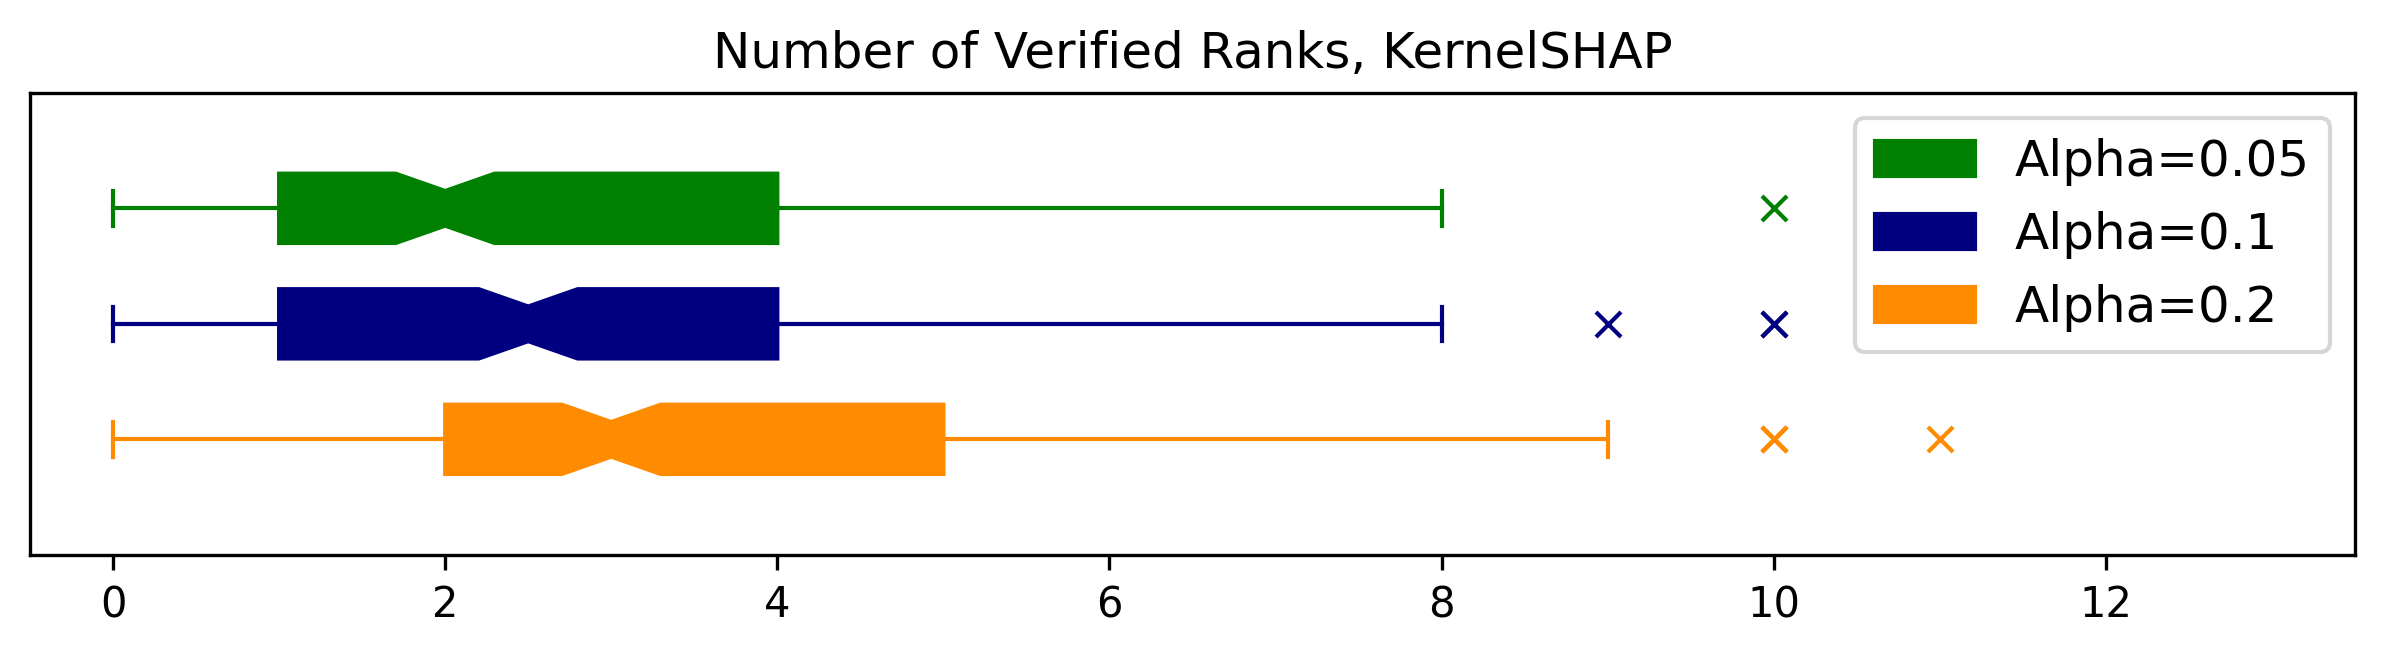

In [41]:
offset = 0.25#0.5
plt.figure(figsize=(10,2), dpi=300)
colors = ["green", "navy", "darkorange"]
offsets = np.array([offset, 0, -offset])
for i in range(3):
    c = colors[i]
    off = offsets[i]
    plt.boxplot(N_verified[:, i].T, positions=[off], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c, marker='x'),
            medianprops=dict(color=c), 
            vert=False
            )
    plt.xlim(right=13.5)
    plt.ylim(-.5, .5)

cols = ["Alpha="+str(alpha) for alpha in alphas]
patches = []
for i in range(3):
    patches.append(mpatches.Patch(color=colors[i], label=cols[i]))
plt.legend(handles=patches, fontsize='large', loc='upper right')
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.title("Number of Verified Ranks, KernelSHAP")
plt.savefig(join(dir_path, "Experiments", "Figures", "num_stable_ranks_kshap.pdf"), 
            bbox_inches="tight", format="pdf")
plt.show()
